# Lotka-Volterra equations with learning terms

We tackle Lotka-Volterra system of equations with additional assumpion, that preys learns to avoid predators (and thus live longer), but predators don't improve their hunting skills. We use one-step implicit Euler and four-step Adams-Bashforth methods to numerically solve it.

Assuming $x$ is number of preys and $y$ is number of predators and $t \in [0, +\infty)$, we can write equations:

$$
\begin{split}
    \frac{\,d x}{\,d t} &= ax - \frac{b}{[\ln(e+t)]^k} xy\\
    \frac{\,d y}{\,d t} &= -ry + \frac{c}{[\ln(e+t)]^k} xy.
\end{split}
$$

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import numpy as np
import pandas as pd

import sympy

import plotly.graph_objects as go
from ipywidgets import widgets

import warnings

warnings.filterwarnings("ignore")

## Solution existence

Let
$$
    z = \begin{pmatrix}
        x \\ y
        \end{pmatrix}.
$$
Then
$$
    z' = \begin{pmatrix}
        x' \\ y'
        \end{pmatrix} = \begin{pmatrix}
            ax - \frac{b}{[\ln(e+t)]^k} xy\\
            -ry + \frac{c}{[\ln(e+t)]^k} xy
            \end{pmatrix} = f(t, z)
$$
with initial condition
$$
    z(0) = \begin{pmatrix}
        x_0 \\ y_0
        \end{pmatrix}.
$$

Putting $k=0$ we obtain simple Lotka-Volterra equations where preys don't improve on their survival chances:

$$
\begin{split}
    \frac{\,d x}{\,d t} &= ax - bxy\\
    \frac{\,d y}{\,d t} &= -ry + cxy.
\end{split}
$$

$$
    dx \cdot \frac{r-cx}{x} + dy \cdot \frac{a-by}{y} = 0
$$

[By eliminating time from the equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations#A_simple_example) we can produce a single equation

$$
    \frac{dx}{dy} = \frac{ax - bxy}{-ry + cxy} = -\frac{x}{y}\frac{a - by}{r - cx}.
$$
Then, by separating variables we obtain
$$
    dx \cdot \frac{r-cx}{x} + dy \cdot \frac{a-by}{y} = 0,
$$
$$
    r \ln x - cx + a \ln y - by = C.
$$
However, we won't use this fact later on.

## Implementing methods

### Numerical solution

Some variables' names in code are supposed to resemble literature's notation, for example `f_[k+3]` is $f_{k+3}$.

In [2]:
class BaseSolver:
    """Base class implementing used methods:

    One-step implicit Euler,
    four-step Adams Bashforth
    """
    def dz_over_dt(self, t, z):
        pass
    def dx_over_dt(self, t, x, y):
        pass
    def dy_over_dt(self, t, x, y):
        pass
    

    def Euler_implicit(self, h, iters, simple_iters=5):
        x_ = np.empty((iters+1, 2))
        x_[0, :] = np.array([self.x0, self.y0])

        t_ = np.arange(iters+1) * h

        f = self.dz_over_dt

        # Solving non-linear equation using simple iteration
        for k in range(iters):
            x_new = x_[k]
            for _ in range(simple_iters):
                x_new = x_[k] + h*f(t_[k+1], x_new)
            
            x_[k+1] = x_new
        
        return t_, x_

    def Adams_Bashforth(self, h, iters):
        x_ = np.empty((iters+1, 2))
        x_[0, :] = np.array([self.x0, self.y0])

        t_ = np.arange(iters+1) * h

        f = self.dz_over_dt

        # Runge-Kutta method for first 3 points
        def sumK(h, t, x):
            K1 = f(t, x)
            K2 = f(t + h/2.0, x + h/2.0*K1)
            K3 = f(t + h/2.0, x + h/2.0*K2)
            K4 = f(t + h    , x + h    *K3)
            return K1 + 2.0*K2 + 2.0*K3 + K4

        for k in range(3):
            x_[k+1] = x_[k] + h/6.0*sumK(h, t_[k], x_[k])

        # Adams-Bashforth method from now on
        for k in range(iters+1 - 4):
            x_[k+4] = x_[k+3] + h * (55./24.*f(t_[k+3], x_[k+3])
                                    -59./24.*f(t_[k+2], x_[k+2])
                                    +37./24.*f(t_[k+1], x_[k+1])
                                    - 9./24.*f(t_[k+0], x_[k+0]))

        return t_, x_

$$
\begin{split}
  \frac{\,d x}{\,d t} &= ax - \frac{b}{[\ln(e+t)]^k} xy\\
  \frac{\,d y}{\,d t} &= -ry + \frac{c}{[\ln(e+t)]^k} xy.
\end{split}
$$

In [3]:
class LvLearningTerms(BaseSolver):
    """Representation of a model with given parameters, ready to use methods from above."""
    
    def __init__(self, a, b, r, c, k, x0, y0):
        self.a = a
        self.b = b
        self.r = r
        self.c = c
        self.k = k

        self.x0 = x0
        self.y0 = y0
  

    def dz_over_dt(self, t, z):
        return np.array([self.dx_over_dt(t, z[0], z[1]), self.dy_over_dt(t, z[0], z[1])])

    def dx_over_dt(self, t, x, y):
        return self.a*x - self.b/(np.log(np.e + t))**self.k *x*y

    def dy_over_dt(self, t, x, y):
        return -self.r*y + self.c/(np.log(np.e + t))**self.k *x*y
    

    def Euler_implicit(self, T, n, simple_iters=5):
        h = T / n
        return super().Euler_implicit(h, n, simple_iters)

    def Adams_Bashforth(self, T, n):
        h = T / n
        return super().Adams_Bashforth(h, n)

#### Example problem

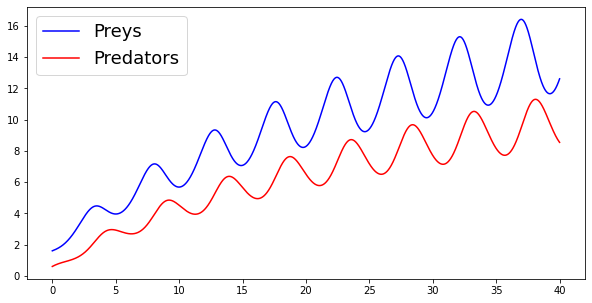

In [4]:
model = LvLearningTerms(a=1.4, b=2.0, r=1.2, c=1.2, k=2.0, x0=1.6, y0=0.6)

ts, xs = model.Adams_Bashforth(T=40.0, n=8000)

plt.figure(figsize=(10, 5))
plt.plot(ts, xs[:, 0], 'b-', label='Preys')
plt.plot(ts, xs[:, 1], 'r-', label='Predators')
plt.legend(loc='upper left', fontsize=18)

### Methods' ranks

#### Calculations

##### Implicit Euler method

$$
    x_{k+1} = x_k + h \cdot f(t_{k+1}, x_{k+1}), \quad k = 0, \ldots , N-1
$$

We write down local error and use Taylor's expansion:
$$
\begin{split}
    r_k(h) &= x(t_{k+1}) - x(t_k) - h \cdot f\Big(t_{k+1}, x(t_{k+1})\Big)\\
    &= x(t_{k+1}) - \bigg( x(t_{k+1}) - hx'(t_{k+1}) + \mathcal{O}(h^2) \bigg) - h \cdot x'(t_{k+1})\\
    &= \mathcal{O}(h^2) \implies p = 1
\end{split}
$$

##### Adams-Bashforth method

$$
    x_{k+4} = x_{k+3} + h \Big( \frac{55}{24}f_{k+3} - \frac{59}{24}f_{k+2} + \frac{37}{24}f_{k+1} - \frac{9}{24}f_{k} \Big)
$$

We employ equivalent condition using characteristic polynomials for multistep methods:
$$
    \rho (\lambda) = \sum_{j=0}^4 \alpha_j \lambda^j, \qquad \sigma (\lambda) = \sum_{j=0}^4 \beta_j \lambda^j
$$
$$
    \rho (\lambda) = \lambda^4 - \lambda^3, \qquad \sigma (\lambda) = \frac{55}{24}\lambda^3 - \frac{59}{24}\lambda^2 + \frac{37}{24}\lambda - \frac{9}{24}
$$

$$
\begin{split}
    c_0 &= \sum_{j=0}^4 \alpha_j = 0 + 0 + 0 - 1 + 1 = 0\\
    c_1 &= \sum_{j=0}^4 \alpha_j \cdot j - \sum_{j=0}^4 \beta_j = \big( 0 + 0 + 0 - 3 + 4 \big) - \big( - \frac{9}{24} + \frac{37}{24} - \frac{59}{24} + \frac{55}{24} \big) = 0\\
    c_2 &= \frac{1}{2}\sum_{j=0}^4 \alpha_j \cdot j^2 - \sum_{j=0}^4 \beta_j \cdot j = \frac{1}{2} \big( 0 + 0 + 0 - 9 + 16 \big) - \big( 0 + \frac{37}{24} \cdot 1 - \frac{59}{24} \cdot 2 + \frac{55}{24} \cdot 3 \big) = 0\\
    c_3 &= \frac{1}{3}\sum_{j=0}^4 \alpha_j \cdot j^3 - \sum_{j=0}^4 \beta_j \cdot j^2 = \frac{1}{3} \big( 0 + 0 + 0 - 27 + 64 \big) - \big( 0 + \frac{37}{24} \cdot 1 - \frac{59}{24} \cdot 4 + \frac{55}{24} \cdot 9 \big) = 0\\
    c_4 &= \frac{1}{4}\sum_{j=0}^4 \alpha_j \cdot j^4 - \sum_{j=0}^4 \beta_j \cdot j^3 = \frac{1}{4} \big( 0 + 0 + 0 - 81 + 256 \big) - \big( 0 + \frac{37}{24} \cdot 1 - \frac{59}{24} \cdot 8 + \frac{55}{24} \cdot 27 \big) = 0\\
    c_5 &= \frac{1}{5}\sum_{j=0}^4 \alpha_j \cdot j^5 - \sum_{j=0}^4 \beta_j \cdot j^4 = \frac{1}{5} \big( 0 + 0 + 0 - 243 + 1024 \big) - \big( 0 + \frac{37}{24} \cdot 1 - \frac{59}{24} \cdot 16 + \frac{55}{24} \cdot 81 \big) = \frac{251}{6} \neq 0\\
    &\implies p = 4
\end{split}
$$

#### Halve step method for estimating rank

In [5]:
class RankEstimator(LvLearningTerms):
    """Complete model with methods designed to estimate the rank."""

    def generate_table(self, T, which_one='euler', sol_grid=100, ns=np.array([80, 160, 320])):
        base_total_grid = ns[-1] * sol_grid
        highest_step = base_total_grid // ns[0]
        total_grid = base_total_grid + 4*highest_step

        self.prepare_stuff(T * total_grid / base_total_grid, total_grid)

        all_local_errors  = []
        all_global_errors = []

        tk = T * (np.arange(ns[0]+1)) / ns[0]

        for n in ns:
            solution_step = base_total_grid // n

            if which_one.lower()=='adams-bashforth':
                local_errors_n, global_errors_n = self.errs_Adams_Bashforth(T, n, solution_step=solution_step)
            elif which_one.lower()=='euler':
                local_errors_n, global_errors_n = self.errs_Euler(          T, n, solution_step=solution_step, simple_iters=5)
            else:
                raise RuntimeError('Nie mamy takiego schematu :(')

            all_local_errors.append(local_errors_n)
            all_global_errors.append(global_errors_n)

        data = {'tk': tk,
                'rk(h)': all_local_errors[0],
                'rk(h/2)': all_local_errors[1][::2],
                'rk(h/4)': all_local_errors[2][::4],
                
                'rk(h)/rk(h/2)' : all_local_errors[0] / all_local_errors[1][::2],
                'rk(h/2)/rk(h/4)' : all_local_errors[1][::2] / all_local_errors[2][::4],
                
                'ek(h)': all_global_errors[0],
                'ek(h/2)': all_global_errors[1][::2],
                'ek(h/4)': all_global_errors[2][::4],
                
                'ek(h)/ek(h/2)' : all_global_errors[0] / all_global_errors[1][::2],
                'ek(h/2)/ek(h/4)' : all_global_errors[1] [::2]/ all_global_errors[2][::4],}

        df = pd.DataFrame(data)

        rk_mean = df[['rk(h)/rk(h/2)', 'rk(h/2)/rk(h/4)']].max(axis=0).mean()
        print(f'\nEstimated error roughly:\t {np.log2(rk_mean) - 1.}.')

        return df


    def prepare_stuff(self, T, n):  # Prepare solution very close to analytical one
        f = self.dz_over_dt
        h = T / n
        t_, self.solution = self.Adams_Bashforth(T, n)
        self.f_ = np.array([f(t_[k], self.solution[k]) for k in range(n)])


    def errs_Euler(self, T, n, solution_step, simple_iters):
        local_errs  =  self.local_errs_Euler(T, n, solution_step)
        global_errs = self.global_errs_Euler(T, n, solution_step, simple_iters)
        return local_errs, global_errs
  
    def errs_Adams_Bashforth(self, T, n, solution_step):
        local_errs  =  self.local_errs_Adams_Bashforth(T, n, solution_step)
        global_errs = self.global_errs_Adams_Bashforth(T, n, solution_step)
        return local_errs, global_errs
  

    def local_errs_Euler(self, T, n, solution_step):
        r_ = np.empty(n+1)
        xt_ = self.solution[::solution_step]
        f_ = self.f_[::solution_step]
        h = T / n
        for k in range(n+1):
            r_[k] = np.linalg.norm(xt_[k+1] - xt_[k] - h * f_[k+1]
                                   , ord=2)
        return r_
    def global_errs_Euler(self, T, n, solution_step, simple_iters):
        _, approximation = self.Euler_implicit(T, n, simple_iters)
        return np.linalg.norm(self.solution[:n*solution_step+1:solution_step] - approximation
                              , ord=2, axis=1)
  
    def local_errs_Adams_Bashforth(self, T, n, solution_step):
        r_ = np.empty(n+1)
        xt_ = self.solution[::solution_step]
        f_ = self.f_[::solution_step]
        h = T / n
        for k in range(n+1):
            r_[k] = np.linalg.norm(xt_[k+4] - xt_[k+3] - h * (55./24.*f_[k+3]
                                                             -59./24.*f_[k+2]
                                                             +37./24.*f_[k+1]
                                                             - 9./24.*f_[k+0])
                                   , ord=2)
        return r_
    def global_errs_Adams_Bashforth(self, T, n, solution_step):
        _, approximation = self.Adams_Bashforth(T, n)
        return np.linalg.norm(self.solution[:n*solution_step+1:solution_step] - approximation
                              , ord=2, axis=1)

In [6]:
estimator = RankEstimator(a=1.4, b=2.0, r=1.2, c=1.2, k=2.0, x0=1.6, y0=0.6)
estimator.generate_table(T=2.0, sol_grid=100, which_one='Euler', ns=np.array([80, 160, 320])).iloc[::8]


Estimated error roughly:	 1.011517400567857.


tk     rk(h)   rk(h/2)   rk(h/4)  rk(h)/rk(h/2)  rk(h/2)/rk(h/4)  \
0   0.0  0.000102  0.000025  0.000006       4.042724         4.021397   
8   0.2  0.000128  0.000032  0.000008       4.031303         4.015876   
16  0.4  0.000149  0.000037  0.000009       4.020712         4.010493   
24  0.6  0.000166  0.000041  0.000010       4.014922         4.007539   
32  0.8  0.000179  0.000045  0.000011       4.011306         4.005715   
40  1.0  0.000190  0.000047  0.000012       4.007769         4.003958   
48  1.2  0.000196  0.000049  0.000012       4.003129         4.001665   
56  1.4  0.000196  0.000049  0.000012       3.996727         3.998500   
64  1.6  0.000188  0.000047  0.000012       3.988324         3.994329   
72  1.8  0.000170  0.000043  0.000011       3.979574         3.989915   
80  2.0  0.000150  0.000038  0.000009       3.981796         3.990661   

       ek(h)   ek(h/2)   ek(h/4)  ek(h)/ek(h/2)  ek(h/2)/ek(h/4)  
0   0.000000  0.000000  0.000000            NaN              NaN  
8   0.001077  0.000532  0.000265       2.022075         2.011175  
16  0.002670  0.001325  0.000660       2.015024         2.007735  
24  0.004664  0.002322  0.001159       2.008112         2.004302  
32  0.006903  0.003448  0.001723       2.001861         2.001187  
40  0.009219  0.004619  0.002312       1.995831         1.998184  
48  0.011415  0.005737  0.002876       1.989494         1.995030  
56  0.013244  0.006681  0.003355       1.982354         1.991476  
64  0.014432  0.007311  0.003679       1.974032         1.987322  
72  0.014752  0.007508  0.003787       1.964810         1.982671  
80  0.014280  0.007292  0.003685       1.958239         1.979166

In [7]:
estimator.generate_table(T=2.0, sol_grid=100, which_one='Adams-Bashforth', ns=np.array([80, 160, 320])).iloc[::8]


Estimated error roughly:	 4.0995293862703.


tk         rk(h)       rk(h/2)       rk(h/4)  rk(h)/rk(h/2)  \
0   0.0  8.800140e-09  2.710795e-10  8.415370e-12      32.463316   
8   0.2  9.091096e-09  2.872387e-10  9.010416e-12      31.649965   
16  0.4  7.173105e-09  2.339977e-10  7.460308e-12      30.654597   
24  0.6  4.327994e-09  1.461783e-10  4.740419e-12      29.607643   
32  0.8  1.895743e-09  6.593101e-11  2.177972e-12      28.753440   
40  1.0  2.120094e-09  6.050580e-11  1.811504e-12      35.039525   
48  1.2  3.833150e-09  1.135082e-10  3.447494e-12      33.769811   
56  1.4  5.193359e-09  1.582911e-10  4.879567e-12      32.808920   
64  1.6  5.704569e-09  1.783396e-10  5.563634e-12      31.987111   
72  1.8  4.919924e-09  1.591134e-10  5.047629e-12      30.920871   
80  2.0  3.955949e-09  1.212290e-10  3.788024e-12      32.632031   

    rk(h/2)/rk(h/4)         ek(h)       ek(h/2)       ek(h/4)  ek(h)/ek(h/2)  \
0         32.212429  0.000000e+00  0.000000e+00  0.000000e+00            NaN   
8         31.878521  4.731368e-08  3.930626e-09  2.769391e-10      12.037187   
16        31.365687  1.412833e-07  1.007091e-08  6.691199e-10      14.028852   
24        30.836575  2.440629e-07  1.668362e-08  1.088198e-09      14.628896   
32        30.271736  3.403765e-07  2.281287e-08  1.474540e-09      14.920374   
40        33.400858  4.213286e-07  2.791307e-08  1.794365e-09      15.094315   
48        32.924838  4.812060e-07  3.162797e-08  2.025444e-09      15.214573   
56        32.439573  5.154806e-07  3.367583e-08  2.150250e-09      15.307142   
64        32.054519  5.215822e-07  3.390903e-08  2.160003e-09      15.381808   
72        31.522399  5.016581e-07  3.249397e-08  2.066179e-09      15.438499   
80        32.003235  4.659755e-07  3.012106e-08  1.913483e-09      15.470089   

    ek(h/2)/ek(h/4)  
0               NaN  
8         14.193106  
16        15.050976  
24        15.331414  
32        15.471172  
40        15.555955  
48        15.615322  
56        15.661352  
64        15.698602  
72        15.726602  
80        15.741483

### Region of abosolute stability

#### Calculations

##### Implicit Euler method

$$
    x_{k+1} = x_k + h \cdot f(t_{k+1}, x_{k+1}), \quad k = 0, \ldots , N-1
$$

Let $\lambda \in \mathbb{C}, \Re({\lambda}) < 0$. We employ the method to test equation:
$$
\begin{split}
    x_{k+1} &= x_k + h \lambda x_{k+1}\\
    \frac{x_{k+1}}{x_k} &= \frac{1}{1 - h \lambda}\\
    R(z) &= \frac{1}{1 - z}
\end{split}
$$
$$
    |R(z)| < 1 \iff |\frac{1}{1 - z}| < 1 \iff 1 < |z - 1|
$$
So we look for such complex numbers $z \in \mathbb{C}$, that are farther from $1$ than $1$, so that build up exterior of unit circle with center in $1$.

##### Adams-Bashforth method

$$
    x_{k+4} = x_{k+3} + h \Big( \frac{55}{24}f_{k+3} - \frac{59}{24}f_{k+2} + \frac{37}{24}f_{k+1} - \frac{9}{24}f_{k} \Big)
$$

We calculate two characteristic polynomials and stability polynomial:
$$
    \rho (\lambda) = \sum_{j=0}^4 \alpha_j \lambda^j, \qquad \sigma (\lambda) = \sum_{j=0}^4 \beta_j \lambda^j
$$
$$
    \rho (\lambda) = \lambda^4 - \lambda^3, \qquad \sigma (\lambda) = \frac{55}{24}\lambda^3 - \frac{59}{24}\lambda^2 + \frac{37}{24}\lambda - \frac{9}{24}
$$

$$
    \pi (\lambda, z) = \rho(\lambda) - z\sigma(\lambda) = \lambda^4 + \Big(-1 - \frac{55}{24}z\Big)\lambda^3 + \frac{59}{24}z\lambda^2 - \frac{37}{24}z\lambda + \frac{9}{24}z
$$

Now we need to find such number $z \in \mathbb{C}$, that all roots of polynomial $\pi (\lambda, z)$ are located inside unit circle with center in $0$.

#### Charts

In [8]:
class AbsStabAreaPainter:
    """Class implementing ploting absolute stability regions for both methods."""

    def plot_Euler(self, grid=1000, low=-3.0, high=3.0):
        xs = ys = np.linspace(low, high, grid)
        xv, yv = np.meshgrid(xs, ys)
        A = xv + 0.0+1.0j * yv
        B = np.abs(A - 1.0) > 1.0

        plt.figure(figsize=(8, 8))
        plt.contourf(xs, ys, B, cmap=plt.cm.BuGn)
        plt.vlines(0, low, high, colors=['black'])
        plt.hlines(0, low, high, colors=['black'])
    
    def plot_Adams_Bashforth(self, grid=300, low=-0.5, high=0.5):
        xs = ys = np.linspace(low, high, grid)
        xv, yv = np.meshgrid(xs, ys)
        A = xv + 0.0+1.0j * yv

        A_rav = A.ravel()
        B = np.zeros_like(A_rav, bool)
        for i, z in enumerate(A_rav):
            poly = np.array([1., (-1. - 55./24.*z), 59./24.*z, -37./24.*z, 9./24.*z])
            roots = np.roots(poly)
            if np.all(np.abs(roots) < 1.0):
                B[i] = True

        B = B.reshape(grid, grid)
        plt.figure(figsize=(8, 8))
        plt.contourf(xs, ys, B, cmap=plt.cm.BuGn)
        plt.vlines(0, low, high, colors=['black'])
        plt.hlines(0, low, high, colors=['black'])

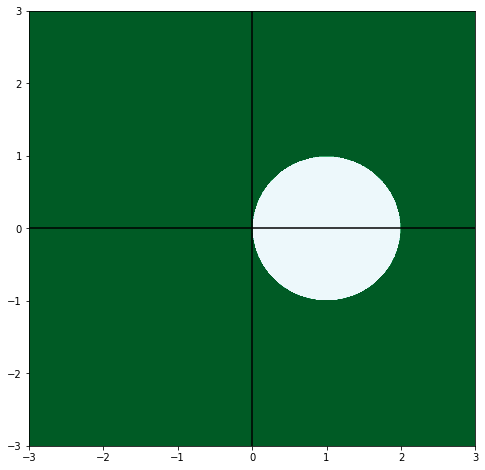

In [9]:
plotter = AbsStabAreaPainter()
plotter.plot_Euler()

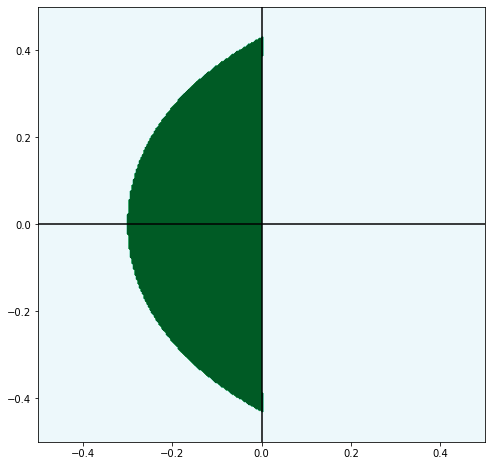

In [10]:
plotter.plot_Adams_Bashforth()

### Linear problem

As simple Lotka-Volterra equations have 2 critical points we could ask whether the equations can be linearized in those points' neighborhood. It turns out that [they can't](https://en.wikipedia.org/wiki/Lotka–Volterra_equations#Stability_of_the_fixed_points). Thus we assume that more complicated equations with learning terms included can't either.

So for our further analysis we may choose different system of equations, for instance
$$\begin{cases}
    x' = -2x + y \\
    y' = -2x - 4y
  \end{cases} \qquad (x(0), y(0)) = (1,2);
$$

In [11]:
class LinearProblem(BaseSolver):
    """Class using both of previous methods for approximating
    a solution of 2x2 system in matrix A.
    """
    def __init__(self, A, x0, y0):
        self.A = A
        self.x0 = x0
        self.y0 = y0
    

    def dz_over_dt(self, t, z):
        return self.A @ z
    def dx_over_dt(self, t, x, y):
        return self.A[0, :] @ np.array([x, y])
    def dy_over_dt(self, t, x, y):
        return self.A[1, :] @ np.array([x, y])
    

    def find_char_poly(self):
        """Find characteristic polynomial of A."""
        
        M = sympy.Matrix(self.A)
        phi = M.charpoly()
        roots = phi.all_roots()
        self.eigenvalues = roots
        print(f'Char poly: {phi.as_expr()},\troots: {roots}')
    
    
    def find_h_Euler(self):
        """Find limit for step h to keep stability."""
        
        self.find_char_poly()
        h = sympy.symbols('h', real=True)
        z = self.eigenvalues[0]
        h = sympy.solve(sympy.Eq(sympy.Abs(z-1), 1), minimal=True)
        self.h = h
        print(f'h = {h}')
        
    def find_h_Adams_Bashforth(self, starting_h=0.1, jump=0.5, turns=40):
        """Find limit for step h to keep stability."""
        
        self.find_char_poly()
        lambda_ = complex(self.eigenvalues[0])
        h = starting_h
        change = starting_h
        for turn in range(turns):
            z = lambda_ * h
            poly = np.array([1., (-1. - 55./24.*z), 59./24.*z, -37./24.*z, 9./24.*z])
            roots = np.roots(poly)
            while ((np.all(np.abs(roots) < 1.0)) if turn%2==0 else (np.any(np.abs(roots) >= 1.0))):
                h = h + change*(-1.)**turn
                z = lambda_ * h
                poly = np.array([1., (-1. - 55./24.*z), 59./24.*z, -37./24.*z, 9./24.*z])
                roots = np.roots(poly)
            change *= jump
        self.h = h
        print(f'h = {h}')
    

    def solve_plot(self, hs, iters, which_one='euler', simple_iters=1000, lim=5, colors=['blue', 'green', 'red']):
        solutions = []

        if which_one.lower()=='adams-bashforth':
            for h in hs:
                solutions.append((h, self.Adams_Bashforth(h, iters)[1]))
        elif which_one.lower()=='euler':
            for h in hs:
                solutions.append((h, self.Euler_implicit(h, iters, simple_iters)[1]))
        else:
            raise RuntimeError('Nie mamy takiego schematu :(')
        
        plt.figure(figsize=(8, 8))
        for (h, sol), col in zip(solutions, colors):
            plt.plot(sol[:, 0], sol[:, 1], label=r'$h={}$'.format(h), color=col)
        
        plt.xlabel(r'$x_1$', fontsize=24)
        plt.ylabel(r'$x_2$', fontsize=24, rotation=0)
        plt.legend(fontsize=14)
        plt.xlim(-lim, lim)
        plt.ylim(-lim, lim)

In [12]:
M = np.array([[-2.0,  1.0],
              [-2.0, -4.0]])
linear_problem = LinearProblem(M, x0=1.0, y0=2.0)
linear_problem.find_h_Euler()

Char poly: 1.0*lambda**2 + 6.0*lambda + 10.0,	roots: [-3 - I, -3 + I]
h = []


Since there is no bound for $h$ Euler method should converge for any value of $h$.

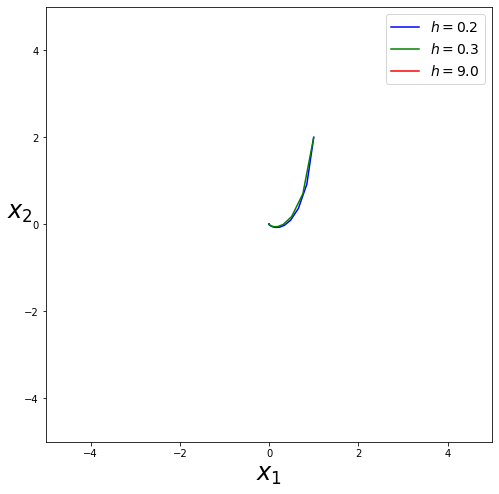

In [13]:
linear_problem.solve_plot([0.2, 0.3, 9.0], iters=100, which_one='Euler', simple_iters=400)

In [14]:
linear_problem.find_h_Adams_Bashforth()

Char poly: 1.0*lambda**2 + 6.0*lambda + 10.0,	roots: [-3 - I, -3 + I]
h = 0.09608329879811209


The above value of $h$ is the one that divides the set of possible values of $h$ into two that contains values for whiches the method converges and diverges respectively.

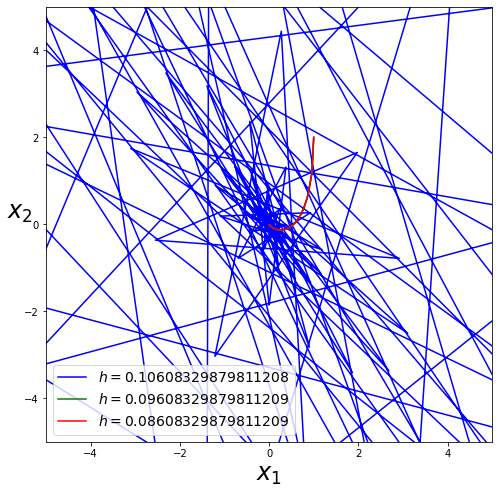

In [15]:
linear_problem.solve_plot(np.array([0.01, 0.0, -0.01]) + linear_problem.h, iters=200, which_one='Adams-Bashforth')

### Interactive chart

In [16]:
# requires ipywidgets

parameters = dict(value=1.0, min=0.0, max=4.0,
                  step=0.2, continuous_update=False)

a  = widgets.FloatSlider(description='a:',  **parameters)
b  = widgets.FloatSlider(description='b:',  **parameters)
r  = widgets.FloatSlider(description='r:',  **parameters)
c  = widgets.FloatSlider(description='c:',  **parameters)
k  = widgets.FloatSlider(description='k:',  **parameters)
x0 = widgets.FloatSlider(description='x0:', **parameters)
y0 = widgets.FloatSlider(description='y0:', **parameters)

T = widgets.FloatSlider(value=20.0, min=1.0, max=40.0,
    step=1.0, description='T:', continuous_update=False)
n = widgets.IntSlider(value=8000, min=50, max=12000,
    step=50, description='n:', continuous_update=False)

container1 = widgets.HBox(children=[a, b])
container2 = widgets.HBox(children=[r, c])
container3 = widgets.HBox(children=[x0, y0])
container4 = widgets.HBox(children=[k])
container5 = widgets.HBox(children=[T, n])

ts, xs = LvLearningTerms(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0).Euler_implicit(20.0, 8000)
trace1 = go.Scatter(x=ts, y=xs[:, 0], name='Preys  (x)')
trace2 = go.Scatter(x=ts, y=xs[:, 1], name='Predators (y)')
g = go.FigureWidget(data=[trace1, trace2],
                    layout=go.Layout(
                        title=dict(
                            text='Learning terms'
                        ),
                        xaxis=dict(title=r'$t$'),
                        yaxis=dict(title='Population')
                    ))

def response(change):
    ts, xs = LvLearningTerms(a.value, b.value,
                             r.value, c.value,
                             k.value,
                             x0.value, y0.value).Euler_implicit(T.value, n.value)
    with g.batch_update():
        g.data[0].x = ts
        g.data[0].y = xs[:, 0]
        g.data[1].x = ts
        g.data[1].y = xs[:, 1]


a.observe( response, names="value")
b.observe( response, names="value")
r.observe( response, names="value")
c.observe( response, names="value")
k.observe( response, names="value")
x0.observe(response, names="value")
y0.observe(response, names="value")
T.observe( response, names="value")
n.observe( response, names="value")

widgets.VBox([container1,
              container2,
              container3,
              container4,
              container5,
              g])